### Classification CNN

Train a CNN to classify images into FRI, FRII, bent-tailed and compact radio galaxy morphologies.

Compare the loss and classification accuracy of the model when trained real data, and on a combination of real and synthetic data (from simple geometric simulation and GANs).

Contents:

1. Load, sigma-clip, resize, augment real data
2. Load trained generator models for each class and build training dataset
3. Load geometric simulation synthetic data
4. Create datasets:
    - test set (contains only real images, 40 from each class)
    - (a) = real images
    - (b) = combination of real and geometric simulation images
    - (c) = combination of real and GAN synthetic images
5. Train CNN model for each dataset
6. Plot loss and accuracy metrics for each dataset
7. Plot confusion matrices for each dataset

In [1]:
from __future__ import absolute_import, division, unicode_literals
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy import stats
from skimage.transform import resize
from scipy.ndimage import rotate # could use skimage rotate
import sys
import time
from IPython import display
#import os
#from astropy.io import fits

# Mount google drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
## Define required functions

def load_and_prep_data(filepath, crop_size=None, downsample_size=None):
    '''
    Load and prepare data from a .npy file
    Returns 3D array of images
    '''
    # Load data
    images = np.load(filepath, allow_pickle=True)
    num_images, image_size, _ = images.shape

    # Sigma clip data
    sigma = 3
    for i in range(num_images):
        _, median, std = stats.sigma_clipped_stats(images[i], sigma=sigma)
        images[i][images[i] < median+sigma*std] = median+sigma*std

    # Crop data
    if crop_size != None:
        low_idx, upper_idx = image_size//2-crop_size//2, image_size//2+crop_size//2
        images = images[:, low_idx:upper_idx, low_idx:upper_idx]

    # Resize data (downsampling)
    if downsample_size != None:
        images = resize(images, (num_images, downsample_size, downsample_size))

    # Normalise data [-1,1]
    for i in range(num_images):
        images[i] = 2*(images[i]-np.min(images[i]))/np.ptp(images[i])-1

    return images

def train_test_idv_class(images, test_num, shuffle=True):
    '''
    Splits an array of images into a training set and a test set
    Returns separate image arrays
    '''
    if shuffle:
        # Shuffles images, so not the same test images every time
        np.random.shuffle(images)
    train = images[test_num:]
    test = images[:test_num]
    return train, test

def augment_data_idv_class(data, n, method='random'):
    '''
    Augment an array of images using rotations and flips
    Returns the augmented array
    n = desired final number of images
    'random' method chooses a random image, random rotation angle and random
    flip for each augmented image
    'ordered' method rotates all images the same number of times (+-1), by a fixed
    angle each time to make up the desired number of images. Every other augmented
     image is flipped.
    '''
    start_time = time.time()
    
    num_images, size, _ = data.shape
    num_extra = n - num_images
    augmented_data = np.empty((n, size, size)) # empty array to store images
    augmented_data[:num_images] = data # fill start with the real images
    
    if method == 'random':
        for i in range(num_images, n):
            flip = np.random.choice([True, False])
            angle = 360*np.random.random()
            image_idx = np.random.randint(num_images)
            image = data[image_idx]
            if flip: image = np.fliplr(image)
            augmented_data[i] = rotate(image, angle, reshape=False, cval=-1)
            
    elif method == 'ordered':
        # some images need one more rotation to make up exactly n images overall
        rotations_per_image, num_extra_rotation = divmod(num_extra, num_images)
        # create arrays for each rotation angle and image index for augmentation
        angles1 = np.linspace(0, 360, rotations_per_image+1, endpoint=False)[1:] # len(angles1) = rotations_per_image
        angles2 = np.linspace(0, 360, rotations_per_image+2, endpoint=False)[1:]
        angles = np.concatenate((np.tile(angles2, num_extra_rotation),np.tile(angles1, num_images-num_extra_rotation)))
        assert len(angles) == num_extra
        # could use np.repeat instead of nested for loops
        idxs1 = [i for i in range(num_extra_rotation, num_images) for _ in range(rotations_per_image)]
        idxs2 = [i for i in range(num_extra_rotation) for _ in range(rotations_per_image+1)]
        image_idxs = np.concatenate((idxs2, idxs1))
        assert len(angles) == len(image_idxs)
        for i in range(num_extra):
            image = data[image_idxs[i]]
            if i%2 == 0: image = np.fliplr(image)
            augmented_data[i+num_images] = rotate(image, angles[i], reshape=False, cval=-1)
            
    print('Augmentation time: {:02d}:{:02d}'.format(*divmod(round(time.time()-start_time), 60)))
    return augmented_data

def add_gauss(im, mu_x, mu_y, sigma_x, sigma_y, theta, A):
    '''
    Add a 2D ellipical gaussian to an image
    Gaussian defined by general equation
    '''
    x, y = np.meshgrid(range(im.shape[0]), range(im.shape[1]))
    a = np.cos(theta)**2/(2*sigma_x**2) + np.sin(theta)**2/(2*sigma_y**2)
    b = -np.sin(2*theta)/(4*sigma_x**2) + np.sin(2*theta)/(4*sigma_y**2)
    c = np.sin(theta)**2/(2*sigma_x**2) + np.cos(theta)**2/(2*sigma_y**2)
    g = A*np.exp(-(a*(x-mu_x)**2 + 2*b*(x-mu_x)*(y-mu_y) + c*(y-mu_y)**2)) # 2D Gaussian general formula (pixel values)
    return im + g

def normalise(im):
    # Normalise image to [-1,1]
    return 2*(im-np.min(im))/np.ptp(im)-1

def sim_compact():
    '''
    Simple geometric simulation for compact sources
    Just a single Gaussian near the centre of the image
    '''
    dim = 56 # image dimension
    # Random variables
    cent_x, cent_y = np.random.normal(dim//2, scale=3, size=2) # black hole location
    sigma = np.abs(np.random.normal(0, scale=0.5, size=1))+0.4
    angle = np.random.rand()*np.pi
    
    # Create blank image and add black hole and tails at calculated coords
    image = np.zeros((dim, dim))
    image = add_gauss(image, cent_x, cent_y, sigma, sigma+np.random.rand()*0.02, angle, np.random.rand()+0.1)
    image = normalise(image)
    return image

def my_model():
    # Alhassan model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(56, 56, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(194, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(194, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')])
    return model

def my_model_alt():
    # Alternative testing model
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', input_shape=(56, 56, 1)),
        #layers.BatchNormalization(),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(194, (3, 3), padding='same'),
        layers.ReLU(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(194, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')])
    return model

def plot_confusion_matrix(cm, ax, title=None, threshold=None, textcolors=['w', 'k'], norm=False):
    # Plot confusion matrix on given axis
    y, x = cm.shape
    if norm: cm = cm / cm.sum(axis=1)[:, np.newaxis]
    vmin, vmax = 0, np.max(cm.sum(axis=1))
    im = ax.imshow(cm, vmin=vmin, vmax=vmax)

    cbar = ax.figure.colorbar(im)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(y))
    ax.set_yticks(np.arange(x))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
    
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')

    # Normalize the threshold to the images color range (for text annotation color)
    if threshold is not None: threshold = im.norm(threshold)
    else: threshold = im.norm(cm.max())/2.

    kw = dict(ha="center", va="center")

    for i in range(y):
        for j in range(x):
            kw.update(color=textcolors[int(im.norm(cm[i, j]) > threshold)])
            text = ax.text(j, i, "{:.3f}".format(cm[i, j]), **kw)

    ax.set_title(title)

def compute_confusion_matrix(true, pred, num_classes):
    '''
    Compute a confusion matrix that takes into account all of the probabilities 
    of a prediction, not just the highest class
    '''
    result = np.zeros((num_classes, num_classes))
    for i in range(len(true)):
        result += np.matmul(np.reshape(true[i], (num_classes,1)), np.reshape(pred[i], (1,num_classes)))
        #alt: result[test_label,:] = pred (not using one hot encoding)
    return result

In [3]:
print('START')
time0 = time.time()

## Data preparation

# .npy filepaths
fr1_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_fr1.npy'
fr2_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_fr2.npy'
bent_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_bent.npy'
comp_filepath = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Good/good_comp.npy'

crop_size = None
downsample_size = 56

# Load and prepare images
fr1 = load_and_prep_data(fr1_filepath, crop_size, downsample_size)
fr2 = load_and_prep_data(fr2_filepath, crop_size, downsample_size)
bent = load_and_prep_data(bent_filepath, crop_size, downsample_size)
comp = load_and_prep_data(comp_filepath, crop_size, downsample_size)

classifications = [fr1, fr2, bent, comp]
print('Training data: {} fr1 images, {} fr2 images, {} bent images, {} comp images'
      .format(len(fr1), len(fr2), len(bent), len(comp)))

# Augment and label images (labels = 0,1,2,3 for each class)
aug_train_images = []
aug_train_labels = []
aug_test_images = []
aug_test_labels = []
test_images = []
test_labels = []
for i, cls in enumerate(classifications):
    train, test = train_test_idv_class(cls, 40)
    aug_train = augment_data_idv_class(train, 6000, method='ordered')
    aug_train_images.append(aug_train)
    aug_train_labels.append(np.full(6000, i))
    aug_test = augment_data_idv_class(test, 1500, method='ordered')
    aug_test_images.append(aug_test)
    aug_test_labels.append(np.full(1500, i))
    test_images.append(test)
    test_labels.append(np.full(40, i))
aug_train_images = np.concatenate(aug_train_images)
aug_train_labels = np.concatenate(aug_train_labels)
aug_test_images = np.concatenate(aug_test_images)
aug_test_labels = np.concatenate(aug_test_labels)
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Add a channels dimension (needed for CNN)
# Changes from float 64 to 32 to match default keras layer dtype
aug_train_images = aug_train_images[..., tf.newaxis].astype('float32')
aug_test_images = aug_test_images[..., tf.newaxis].astype('float32')
test_images = test_images[..., tf.newaxis].astype('float32')

print(aug_train_images.shape, aug_train_labels.shape)
print(aug_test_images.shape, aug_test_labels.shape)
print(test_images.shape, test_labels.shape)

START
Training data: 220 fr1 images, 405 fr2 images, 226 bent images, 243 comp images
Augmentation time: 00:03
Augmentation time: 00:01
Augmentation time: 00:03
Augmentation time: 00:01
Augmentation time: 00:03
Augmentation time: 00:01
Augmentation time: 00:03
Augmentation time: 00:01
(24000, 56, 56, 1) (24000,)
(6000, 56, 56, 1) (6000,)
(160, 56, 56, 1) (160,)


In [4]:
## Include GAN synthetic images in training data

print('START')
time0 = time.time()

# Load trained generators
fr1_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_fr1_gen_model')
fr2_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_fr1_gen_model')
bent_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_bent_gen_model')
comp_gen_model = models.load_model('/gdrive/My Drive/University of Birmingham/Year 4/Project/Data/Gan/good_comp_gen_model')
display.clear_output(wait=True)

generators = [fr1_gen_model, fr2_gen_model, bent_gen_model, comp_gen_model]

time1 = time.time()
print('Time to load generator models: {:02d}:{:02d}'.format(*divmod(round(time1-time0), 60)))

# Generate images from trained generator
num_images = 6000
batch_size = 200 # Need to generate images in batches, otherwise run out of memory
synthetic_images = []
synthetic_labels = []
for i, gen in enumerate(generators):
    for batch in range(num_images//batch_size):
        noise = tf.random.normal([batch_size, 100])
        generated_images = gen(noise, training=False)
        synthetic_images.append(generated_images)
    synthetic_labels.append(np.full(num_images, i))
synthetic_images = np.concatenate(synthetic_images)
synthetic_labels = np.concatenate(synthetic_labels)

print(synthetic_images.shape, synthetic_labels.shape)

Time to load generator models: 00:20
(24000, 56, 56, 1) (24000,)


In [5]:
## Load dataset of geo sim images

geo_synthetic_images = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Code/Misc/geo_sim_images.npy'
geo_synthetic_labels = '/gdrive/My Drive/University of Birmingham/Year 4/Project/Code/Misc/geo_sim_labels.npy'

geo_synthetic_images = np.load(geo_synthetic_images, allow_pickle=True)
geo_synthetic_labels = np.load(geo_synthetic_labels, allow_pickle=True)

## Create compact geo sim images

n = 6000
comp_images = np.empty((n, 56, 56))
for i in range(n):
    comp_images[i] = sim_compact()
comp_labels = np.full(6000, 3)

geo_synthetic_images = np.concatenate((geo_synthetic_images, comp_images))
geo_synthetic_labels = np.concatenate((geo_synthetic_labels, comp_labels))

geo_synthetic_images = geo_synthetic_images[..., tf.newaxis].astype('float32')

print(geo_synthetic_images.shape, geo_synthetic_labels.shape)

(24000, 56, 56, 1) (24000,)


In [6]:
# Create image and label datasets

combined_images = np.concatenate((aug_train_images, synthetic_images))
combined_labels = np.concatenate((aug_train_labels, synthetic_labels))

geo_combined_images = np.concatenate((aug_train_images, geo_synthetic_images))
geo_combined_labels = np.concatenate((aug_train_labels, geo_synthetic_labels))

test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
aug_test_ds = tf.data.Dataset.from_tensor_slices((aug_test_images, aug_test_labels))

train_ds_1 = tf.data.Dataset.from_tensor_slices((aug_train_images, aug_train_labels)).shuffle(len(aug_train_images))
train_ds_2 = tf.data.Dataset.from_tensor_slices((geo_combined_images, geo_combined_labels)).shuffle(len(geo_combined_images))
train_ds_3 = tf.data.Dataset.from_tensor_slices((combined_images, combined_labels)).shuffle(len(combined_images))

print(aug_train_images.shape, geo_combined_images.shape, combined_images.shape)

(24000, 56, 56, 1) (48000, 56, 56, 1) (48000, 56, 56, 1)


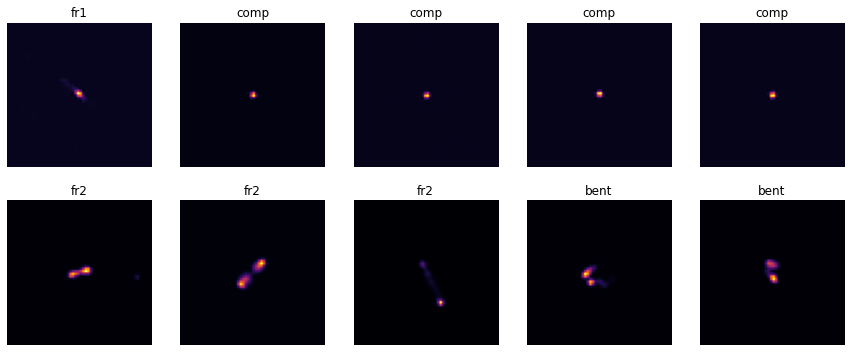

In [14]:
# Plot example labelled data from dataset

def show_batch(dataset):
    image_batch, label_batch = next(iter(dataset.batch(10)))
    plt.figure(figsize=(15,6))
    for n in range(10):
        ax = plt.subplot(2,5,n+1)
        plt.imshow(image_batch[n,:,:,0], cmap='inferno')
        plt.title(class_names[int(label_batch[n])])
        plt.axis('off')
    plt.show()

class_names = ['fr1', 'fr2', 'bent', 'comp']
show_batch(train_ds_1)

In [15]:
## Train model for multiple datasets

datasets = [train_ds_1, train_ds_2, train_ds_3]

batch_size = 128
epochs = 30
dataset_histories = []
trained_models = []

for dataset in datasets:
    start_time = time.time()
    model = my_model()
    model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    history = model.fit(dataset.batch(batch_size), validation_data=aug_test_ds.batch(batch_size), epochs=epochs, verbose=0)
    model.evaluate(aug_test_ds.batch(batch_size), verbose=2)
    model.evaluate(test_ds.batch(batch_size), verbose=2)

    dataset_histories.append(history)
    trained_models.append(model)

    print('Time to build and train the model for {} epochs: {:02d}:{:02d}'.format(epochs, *divmod(round(time.time()-start_time), 60)))

47/47 - 0s - loss: 0.7087 - accuracy: 0.8910
2/2 - 0s - loss: 0.4656 - accuracy: 0.9000
Time to build and train the model for 30 epochs: 01:43
47/47 - 0s - loss: 0.7541 - accuracy: 0.8862
2/2 - 0s - loss: 0.4657 - accuracy: 0.9062
Time to build and train the model for 30 epochs: 03:23
47/47 - 0s - loss: 0.6906 - accuracy: 0.8945
2/2 - 0s - loss: 0.6060 - accuracy: 0.8875
Time to build and train the model for 30 epochs: 03:25


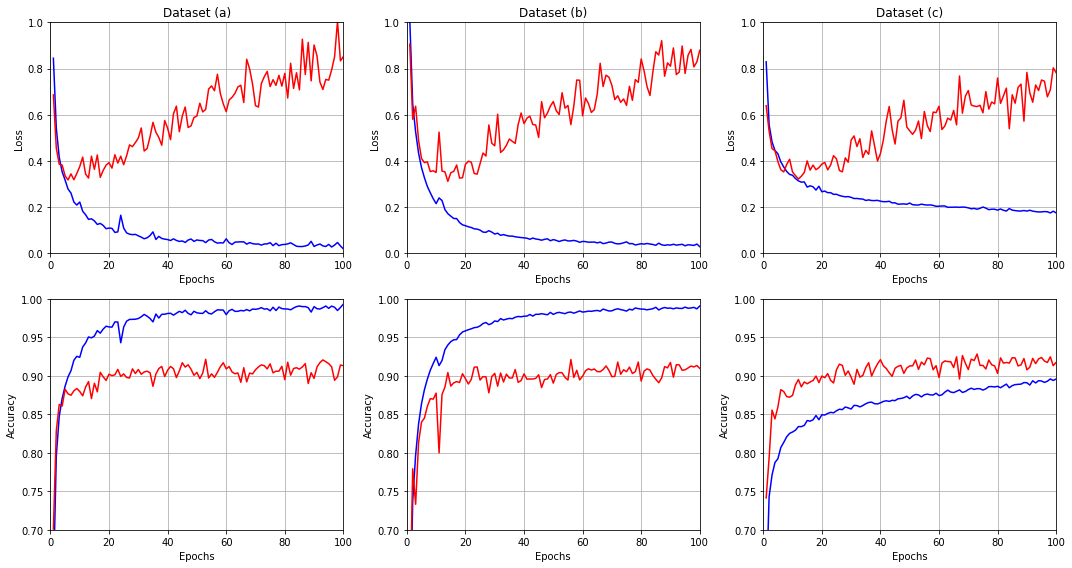

In [0]:
## Plot metrics for each dataset

n = len(datasets)
plot_size = 5
plt.figure(figsize=(n*plot_size, 8))
ds_labels = ['(a)', '(b)', '(c)']

for i in range(n):
    history = dataset_histories[i]
    history_dict = history.history

    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    # loss plot
    ax = plt.subplot(2, n, i+1)
    ax.plot(range(1,epochs+1), loss, 'b-', label='Training loss')
    ax.plot(range(1,epochs+1), val_loss, 'r-', label='Validation loss')
    ax.set_title('Dataset '+ds_labels[i])
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 1)
    ax.grid()
    #ax.legend()

    # acc plot
    ax = plt.subplot(2, n, i+1+n)
    ax.plot(range(1,epochs+1), acc, 'b-', label='Training acc')
    ax.plot(range(1,epochs+1), val_acc, 'r-', label='Validation acc')
    #ax.set_title('Training and validation accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(0, 100)
    ax.set_ylim(0.7, 1)
    ax.grid()
    #ax.legend()

plt.tight_layout()
plt.savefig('/gdrive/My Drive/University of Birmingham/Year 4/Project/temp/acc_loss.png')
plt.show()

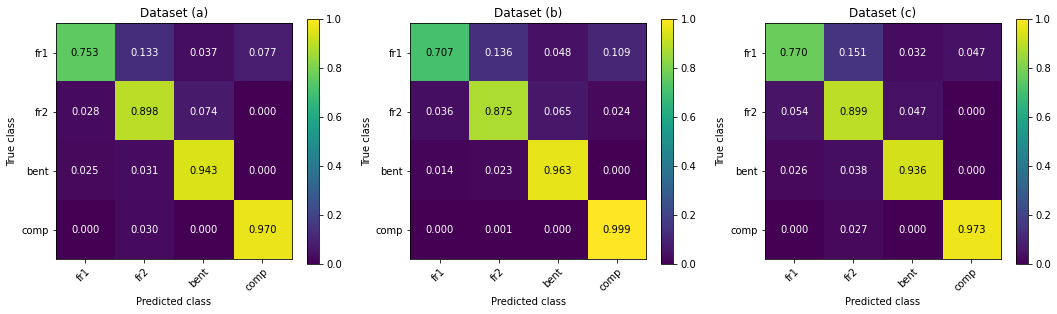

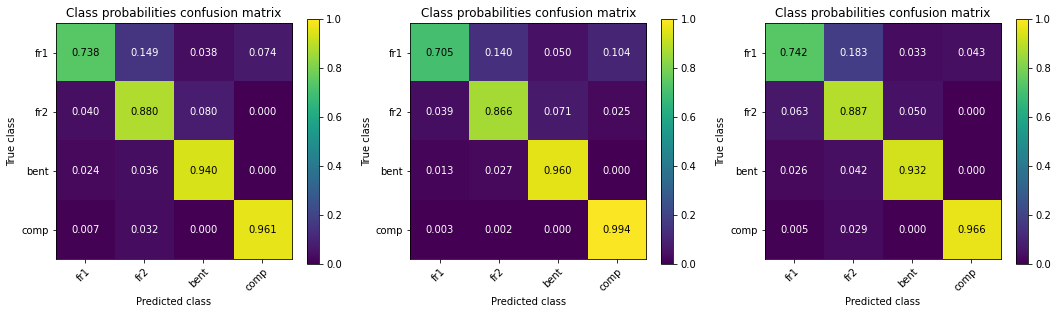

In [18]:
## Plot confusion matrix for each dataset

models = trained_models
ds_labels = ['(a)', '(b)', '(c)']
n = 3

# Confusion matrices based on predicted class
plot_size = 6
plt.figure(figsize=(n*plot_size, plot_size*3/4))
for i, model in enumerate(models):
    ax = plt.subplot(1, n, i+1)
    class_names = ['fr1', 'fr2', 'bent', 'comp']
    test_predictions = model.predict_classes(aug_test_images)
    confusion_matrix = tf.math.confusion_matrix(aug_test_labels, test_predictions, num_classes=4)
    plot_confusion_matrix(confusion_matrix.numpy(), ax, title='Dataset '+ds_labels[i], norm=True)
#plt.tight_layout()
    
# Confusion matrices based on probabilities for all classes
plt.figure(figsize=(n*plot_size, plot_size*3/4))
for i, model in enumerate(models):
    model = trained_models[i]
    ax = plt.subplot(1, n, i+1)
    class_names = ['fr1', 'fr2', 'bent', 'comp']
    test_predictions = model.predict(aug_test_images)
    one_hot_test_labels = tf.one_hot(aug_test_labels, 4)
    confusion_matrix = compute_confusion_matrix(one_hot_test_labels, test_predictions, 4)
    plot_confusion_matrix(confusion_matrix, ax, title='Class probabilities confusion matrix', norm=True)

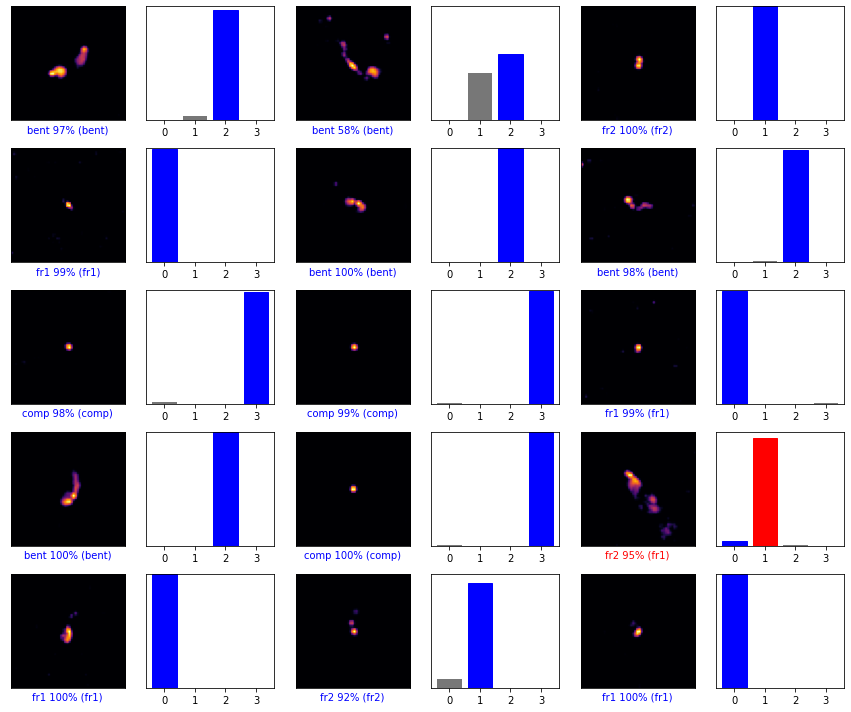

In [19]:
## Plot images alongside classification probabilities

class_names = ['fr1', 'fr2', 'bent', 'comp']

predictions = models[0].predict(test_images)

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[:,:,0]+1.1, cmap='inferno', norm=colors.LogNorm())#, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
#for i in range(num_images):
for i, idx in enumerate(np.random.choice(range(len(test_images)), size=num_images, replace=False)):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(idx, predictions[idx], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(idx, predictions[idx], test_labels)
plt.tight_layout()
plt.show()